# Sentiment Analysis of Tweets directed at Brands and Products

## 1.0 Business Understanding

In today’s digital age, customers frequently share their opinions about products and brands on social media platforms like Twitter. These opinions provide valuable insights for companies to understand customer satisfaction, detect dissatisfaction early, and improve their products or services.

The business problem is to automatically identify the sentiment expressed in tweets about Apple and Google products. By classifying tweets as positive, negative, or neutral, businesses can:

1. Monitor brand reputation in real time.

2. Track how customers respond to new product releases or updates.

3. Identify areas for improvement based on negative feedback.

4. Support data-driven decision-making in marketing and product strategy.

The ultimate goal is to build a sentiment analysis model that helps businesses quickly interpret large volumes of customer feedback without manual review.

## 2.0 Data Understanding

The dataset comes from CrowdFlower and contains over 9,000 tweets related to Apple and Google products. Each tweet has been human-labeled for sentiment as:

1. Positive emotion

2. Negative emotion

3. No emotion toward brand/product

4. Unclear/I can’t tell

##### Key characteristics:

* Textual Data: Tweets are short, noisy, and often contain slang, hashtags, mentions, and URLs, which makes preprocessing crucial.

* Target Variable: The label indicating whether a sentiment is directed at a brand or product.

* Class Distribution: The dataset is slightly imbalanced, with more neutral/no-emotion tweets compared to positive or negative ones.

This dataset is well-suited for the business problem because it directly reflects real customer opinions on social media about Apple and Google. The labeled sentiments provide a foundation for training supervised machine learning models to classify unseen tweets in real time.

In [46]:
# ==============================
# Data Handling & Numerical Tools
# ==============================
import pandas as pd
import numpy as np
import re

# ==============================
# Visualization
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Natural Language Processing (NLTK)
# ==============================
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# NLTK downloads
nltk.download('punkt')       # Tokenizer models
nltk.download('stopwords')   # Common stopwords
nltk.download('wordnet')     # WordNet lexical database
nltk.download('omw-1.4')     # Open Multilingual WordNet
nltk.download("averaged_perceptron_tagger")

# ==============================
# Feature Extraction
# ==============================
from sklearn.feature_extraction.text import TfidfVectorizer

# ==============================
# Model Selection & Evaluation
# ==============================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ==============================
# Handling Class Imbalance
# ==============================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# ==============================
# Machine Learning Models
# ==============================
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# ==============================
# Deep Learning (Optional)
# ==============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\erastus.kaiba\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [47]:
import nltk
print(nltk.data.path)


['C:\\Users\\erastus.kaiba/nltk_data', 'c:\\Users\\erastus.kaiba\\AppData\\Local\\anaconda3\\envs\\learn-env\\nltk_data', 'c:\\Users\\erastus.kaiba\\AppData\\Local\\anaconda3\\envs\\learn-env\\share\\nltk_data', 'c:\\Users\\erastus.kaiba\\AppData\\Local\\anaconda3\\envs\\learn-env\\lib\\nltk_data', 'C:\\Users\\erastus.kaiba\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


## 3.0 Exploratory Data Analysis

In [48]:
# Loading dataset

df = pd.read_csv("Data\judge-1377884607_tweet_product_company.csv",encoding="latin1")

# Quick overview
print(df.shape)
print("\n")
df.info()
print("\n")
df.head()


(9093, 3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB




,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset has 9093 rows and 3 columns.

Key columns of interest:

* tweet_text → raw tweet ( The input feature)

* is_there_an_emotion_directed_at_a_brand_or_product → target sentiment

* emotion_in_tweet_is_directed_at → optional metadata (brand/product mentioned)

In [49]:
# Checks for Missing Values
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

tweet_text: 1 missing value

emotion_in_tweet_is_directed_at: ~5,800 missing (not essential for sentiment task)

is_there_an_emotion_directed_at_a_brand_or_product: no missing values

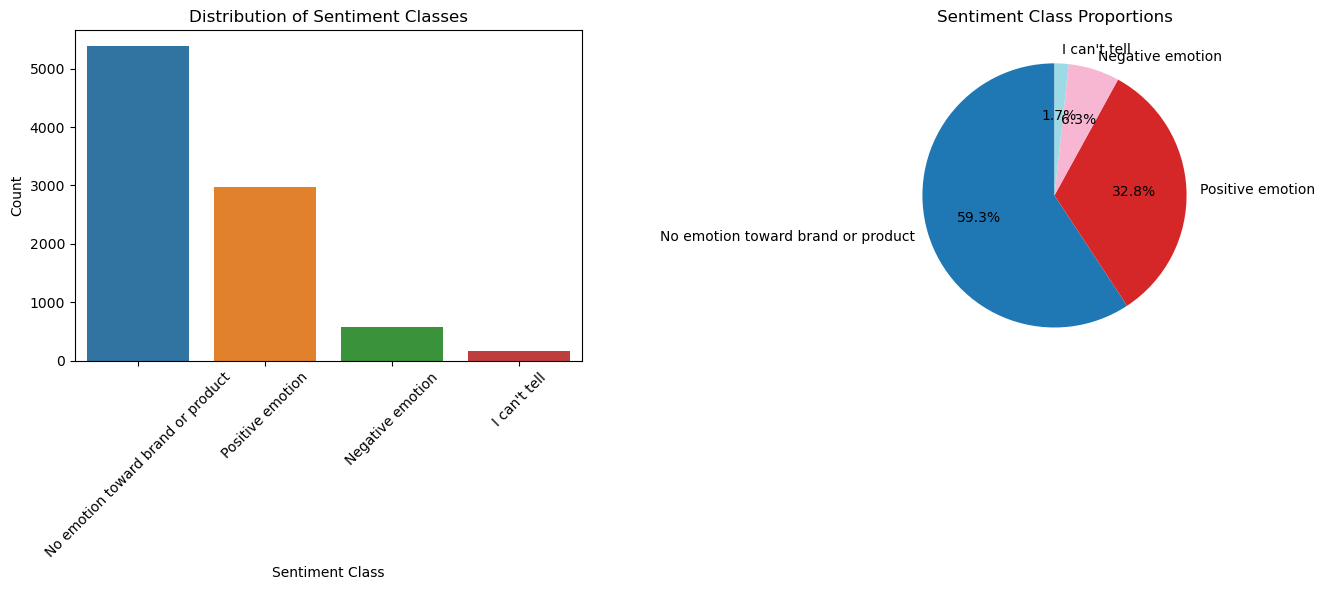

In [50]:
# Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # one row, two columns

# --- Countplot on the left ---
sns.countplot(
    x=df['is_there_an_emotion_directed_at_a_brand_or_product'],
    order=df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().index,
    ax=axes[0]
)
axes[0].set_title("Distribution of Sentiment Classes")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_xlabel("Sentiment Class")
axes[0].set_ylabel("Count")

# --- Pie chart on the right ---
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', ax=axes[1], startangle=90, cmap='tab20'
)
axes[1].set_ylabel("")  # remove y-label
axes[1].set_title("Sentiment Class Proportions")

plt.tight_layout()
plt.show()

The dataset contains four target categories: Positive emotion, Negative emotion, No emotion toward brand or product, and I can’t tell. An imbalance is evident across these classes, with the No emotion category appearing more frequently than the Positive emotion category.

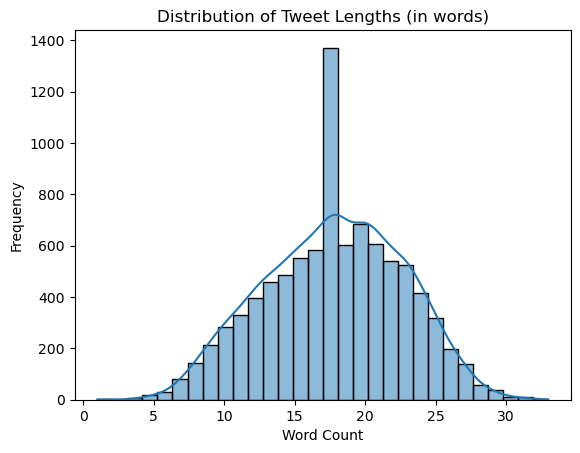

In [51]:
# Tweet Length Analysis
df['tweet_length'] = df['tweet_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


Most tweets range between 5–25 words, with a few outliers that are either very short (1–2 words) or unusually long.

## 4.0  Data Preparation

In [52]:
# Handles Missing Values

# Drop rows with null tweets (main feature)
df = df.dropna(subset=['tweet_text'])

# Verify shape after dropping
print("Shape after dropping null tweet_text:", df.shape)

# Check target distribution
print("\nTarget value counts:")
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())


Shape after dropping null tweet_text: (9092, 4)

Target value counts:
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


Dataset Overview After Cleaning

After removing rows with missing tweet_text, the dataset contains 9,092 records.

The distribution of target labels indicates a noticeable class imbalance:

* No emotion toward brand or product: 5,388

* Positive emotion: 2,978

* Negative emotion: 570

* I can’t tell: 156

The No emotion category is the majority class, while Negative and I can’t tell are underrepresented

In [53]:
df['is_there_an_emotion_directed_at_a_brand_or_product']= df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    'No emotion toward brand or product': 'Neutral',
    "I can't tell": 'Neutral'
})

print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

Neutral             5544
Positive emotion    2978
Negative emotion     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


In [54]:
# Binary Classification Setup
# Keep only Positive and Negative emotions
df_binary = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion'])]

# Check new shape and distribution
print("Shape of binary dataset:", df_binary.shape)
print("\nBinary target distribution:")
print(df_binary['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())


Shape of binary dataset: (3548, 4)

Binary target distribution:
Positive emotion    2978
Negative emotion     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


For the binary classification task, only the Positive emotion and Negative emotion classes were retained, resulting in a dataset of 3,548 records, where Positive emotion (2,978) substantially outnumbers Negative emotion (570), indicating class imbalance.

## 5.0 NLP Pre-Processing

### 5.1 Text preprocessing 

Tweets contain noise such as URLs, hashtags, mentions, punctuation, numbers, and filler words (stopwords). If we feed this raw text directly into a model, it can mislead the classifier. Therefore, we clean and normalize the text so that the model focuses only on meaningful tokens.

In [55]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions & hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords + lemmatize
    return ' '.join(tokens)

# # Apply cleaning to tweets
# df['cleaned_tweet'] = df['tweet_text'].apply(clean_text)


# # Preview cleaned text
# df[['tweet_text', 'cleaned_tweet']].head()

# Binary dataset
df_binary = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(
    ['Positive emotion', 'Negative emotion']
)].copy()

df_binary['cleaned_tweet'] = df_binary['tweet_text'].apply(clean_text)


### 5.2  Encode Labels

Machine learning models work with numbers, not strings → we use Label Encoding to convert classes into integers.

In [56]:
label_encoder = LabelEncoder()
df_binary['label'] = label_encoder.fit_transform(
    df_binary['is_there_an_emotion_directed_at_a_brand_or_product'])

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Negative emotion': 0, 'Positive emotion': 1}


### 5.3 Train-Test Split

In [57]:

#  we test on 20% of the data, stratifying to maintain class balance

X = df_binary['cleaned_tweet']
y = df_binary['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# After split: check training distribution
print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

# After split: check testing distribution
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))


Training set class distribution:
1    0.839323
0    0.160677
Name: label, dtype: float64

Test set class distribution:
1    0.839437
0    0.160563
Name: label, dtype: float64


## 6.0 Modelling and Evaluation

The TF-IDF Vectorizer (Term Frequency–Inverse Document Frequency) transforms text data into numerical features that reflect the importance of words in documents relative to a corpus. It helps highlight words that are more relevant to specific documents while down-weighting common words that appear frequently across all documents.

### 6.1 Baseline Model Benchmarking with Cross-Validation Pipeline

We build and compare multiple models, we then evaluate algorithms such as **Logistic Regression, Random Forest, Gradient Boosting, AdaBoost, and XGBoost**. This helps us benchmark performance and identify the best model for our dataset.

**The TF-IDF Vectorizer** (Term Frequency–Inverse Document Frequency) transforms text data into numerical features that reflect the importance of words in documents , It helps highlight words that are more relevant to specific documents while down-weighting common words that appear frequently across all documents.

**Cross-Validation:** Evaluates models consistently using 5-fold CV and accuracy scoring.

**smote** – Balances minority class by generating synthetic samples.



In [58]:
#This step trains each model on multiclass sentiment labels using TF-IDF features, 
# applies SMOTE balancing, and prints cross-validation accuracy.

# Define models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier( eval_metric='mlogloss'),
}

# Function to train and evaluate with cross-validation
def evaluate_models(models, X_train, y_train):
    results = {}
    for name, model in models.items():
        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))), #Convert raw text into numerical features using TF-IDF.
            ("oversample", RandomOverSampler(random_state=42)),
            ('clf', model)
        ])
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro')
        results[name] = scores.mean()
        print(f"{name}: {scores.mean():.4f}")
    return results

results = evaluate_models(models, X_train, y_train)


Naive Bayes: 0.6788
Logistic Regression: 0.7119
Random Forest: 0.7048
Gradient Boosting: 0.6319
AdaBoost: 0.6306
XGBoost: 0.6737


### 6.2 Pick Best Model and Retrain


In [59]:
# Pick the best model based on cross-validation accuracy and retrain it on the full training set
best_model_name = max(results, key=results.get)
print(f"\nBest model: {best_model_name} with accuracy {results[best_model_name]:.4f}") 


Best model: Logistic Regression with accuracy 0.7119


In [60]:
# refit the best model pipeline on training data  
# our best Model is Logistic with accuracy 0.7119
best_pipeline = ImbPipeline([
       ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
      ("oversample", RandomOverSampler(random_state=42)),
    ('clf', models[best_model_name])])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('oversample', RandomOverSampler(random_state=42)),
                ('clf', LogisticRegression(max_iter=1000))])

### 6.3 Evaluate on Test Data
- this helps check the model before tuning it. its a tuning benchmark

----------------------------------------
Classification Reprt: 
               precision    recall  f1-score   support

           0       0.51      0.58      0.54       114
           1       0.92      0.89      0.91       596

    accuracy                           0.84       710
   macro avg       0.71      0.74      0.72       710
weighted avg       0.85      0.84      0.85       710

----------------------------------------
Accuracy:
 0.8436619718309859
----------------------------------------
Confusion Matrix:



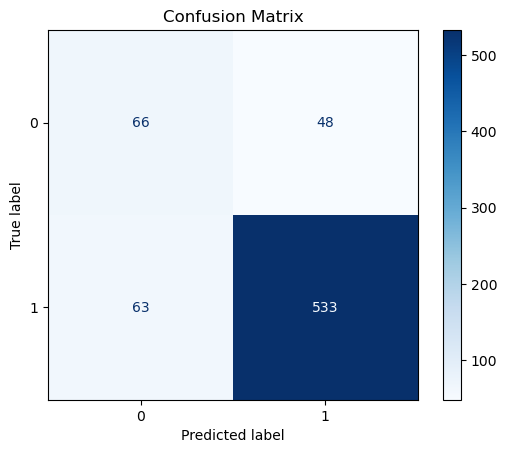

In [61]:
y_pred = best_pipeline.predict(X_test)

print("-"*40)
print( "Classification Reprt: \n",classification_report(y_test, y_pred))
print("-"*40)
print("Accuracy:\n", accuracy_score(y_test, y_pred))
print("-"*40)
print("Confusion Matrix:\n")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### **Observations**
- Overall Accuracy is high (84%), so the model is performing well,But class imbalance is visible:

Class 1 is dominant → model is excellent at detecting it (Recall = 0.89).

Class 0 is under-represented → model struggles (Recall = 0.058).



### 6.4 Best Model Hyperparameter Tuning (with TF-IDF )
Random Forest was best, but we can try RandomizedSearchCV to see if tuning improves performance.

In [62]:
# Define parameter distributions for Logistic Regression + TF-IDF
param_dist = {
    "tfidf__max_features": [5000, 7000, 10000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": np.logspace(-3, 2, 6),   # Regularization strength
    "clf__penalty": ["l2"],            # Logistic regression works best with L2
    "clf__solver": ["lbfgs", "liblinear"]  # Different solvers
}

# Multiple scoring metrics
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1_macro": "f1_macro"
}

# Build pipeline with Logistic Regression
grid = RandomizedSearchCV(
    ImbPipeline([
        ("tfidf", TfidfVectorizer()),
        ("oversample", RandomOverSampler(random_state=42)),
        ("clf", LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000))
    ]),
    param_distributions=param_dist,
    n_iter=20,   # number of random parameter combinations to try
    cv=3,
    scoring=scoring,
    refit="f1_macro",   # pick the model with best F1 (macro)
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Fit search
grid.fit(X_train, y_train)

# Best model
print("Best Parameters:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

# Assign tuned pipeline as best_pipeline
best_pipeline_tuned = grid.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 7000, 'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 10.0}
Best CV F1 Score: 0.7171336633738945


### 6.5 Model Evaluation and Feature Analysis

The main purpose of model evaluation here is  to determine if the model is reliable enough, identify which classes the model predicts well (e.g., Positive emotions) and which it struggles with (e.g., Negative or Neutral) and guide future improvements like balancing classes, tuning hyperparameters, or changing features.

The main purpose of feature analysis is understanding the decision-making process of the model (interpretability), Validate that the model is learning meaningful patterns, not noise.
Provide actionable insights:
For marketing: see which words trigger positive or negative reactions toward a brand

Test Accuracy: 0.8732

Classification Report:

                  precision    recall  f1-score   support

Negative emotion       0.62      0.56      0.59       114
Positive emotion       0.92      0.93      0.93       596

        accuracy                           0.87       710
       macro avg       0.77      0.75      0.76       710
    weighted avg       0.87      0.87      0.87       710



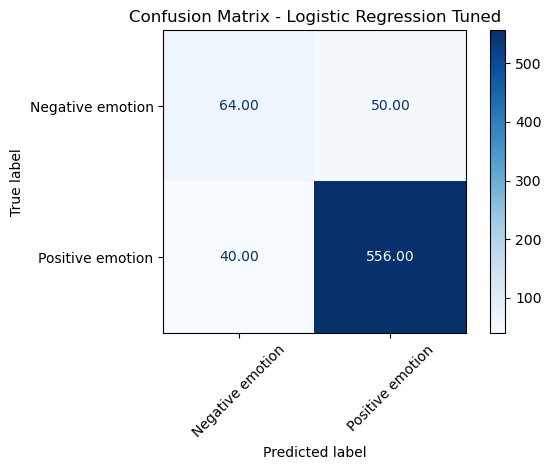

In [63]:


le = LabelEncoder()
le.fit(df_binary['is_there_an_emotion_directed_at_a_brand_or_product'])

# Use only the labels present in y_test
unique_labels = np.unique(y_test)
target_names = le.inverse_transform(unique_labels)

# -----------------------------
# Predictions
# -----------------------------
y_pred_tuned = best_pipeline_tuned.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}\n")


print("Classification Report:\n")
print(classification_report(y_test, y_pred_tuned,target_names=target_names))

# -----------------------------
# Confusion matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix - Logistic Regression Tuned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Some original tweets are "No emotion" or "I can't tell," which are combined into a Neutral class for clarity.

LabelEncoder converts string labels (Positive, Negative, Neutral) into numeric labels the model can understand.

le.fit(df['sentiment']) learns the mapping from string labels → numbers

Accuracy:0.87 → roughly 87% of the tweets were classified correctly, considering all classes.
Model performs very well on Neutral, but struggles on Negative emotion.
Precision vs recall for Negative: 0.62 vs 0.56 → model predicts some Neutral tweets as Negative and misses some actual Negative tweet

### 6.6 Top features evaluation

In [64]:
# Top features 
# -----------------------------
try:
    tfidf = best_pipeline_tuned.named_steps['tfidf']  # direct pipeline
except KeyError:
    preprocessor = best_pipeline_tuned.named_steps['preprocessor']
    tfidf = preprocessor.named_transformers_['text']

# Safe method for feature names
# the purpose here is to the names of all features (words) learned by the TF-IDF vectorizer.
if hasattr(tfidf, "get_feature_names_out"):
    tfidf_features = tfidf.get_feature_names_out()
else:
    tfidf_features = tfidf.get_feature_names()

clf = best_pipeline_tuned.named_steps['clf']

# Handle binary vs multi-class coefficients
if len(clf.coef_) == 1:  # binary classification
    coefs = [ -clf.coef_[0], clf.coef_[0] ]  # class 0 vs class 1
else:  # multi-class
    coefs = clf.coef_

# Show top 10 features per class
# Display the most important features (words) for each class.

# np.argsort(coef)[-10:][::-1] selects indices of the top 10 largest coefficients in descending order.
for i, class_label in enumerate(unique_labels):
    class_name = le.inverse_transform([class_label])[0]
    coef = coefs[i]
    top_idx = np.argsort(coef)[-10:][::-1]
    top_words = [tfidf_features[idx] for idx in top_idx]
    top_scores = coef[top_idx]

    print(f"\nTop 10 features for class '{class_name}':")
    for word, score in zip(top_words, top_scores):
        print(f"{word}: {score:.4f}")

# -----------------------------
# Example predictions
# -----------------------------
print("\nExample predictions:")
sample_size = min(10, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

# Loop through the random samples.
# Retrieves:
# Original tweet text (original_text)
# True sentiment label (true_sentiment)
# Predicted sentiment label (pred_sent_sentiment)
# Prints the text, true label, predicted label, and whether the prediction was correct.
for idx in sample_indices:
    original_text = df.iloc[X_test.index[idx]]['tweet_text']
    true_sentiment = le.inverse_transform([y_test.iloc[idx]])[0]
    pred_sentiment = le.inverse_transform([y_pred_tuned[idx]])[0]

    print(f"\nText: {original_text}")
    print(f"True: {true_sentiment}, Predicted: {pred_sentiment}")
    print("Correct!" if true_sentiment == pred_sentiment else "Incorrect!")


Top 10 features for class 'Negative emotion':
fail: 8.1976
hate: 7.7281
headache: 7.5298
wont: 6.4532
long: 6.3514
ridic: 6.2699
enough: 6.2505
guessing: 5.8135
crash: 5.4487
didnt: 5.2536

Top 10 features for class 'Positive emotion':
link: 7.0654
cool: 5.7888
great: 5.2360
free: 5.1952
awesome: 5.1008
party: 4.8406
winning: 4.5998
week: 4.1931
smart: 3.8862
win: 3.8283

Example predictions:

Text: lonely planet austin guide on the iphone free download for a limited period {link} #sxsw
True: Positive emotion, Predicted: Positive emotion
Correct!

Text: Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
True: Negative emotion, Predicted: Positive emotion
Incorrect!

Text: RT @mention Another great panel at 5 pm at the Hilton - Austin's own @mention Left Brain Search = Google, Right Brain Search = X #sxsw
True: Positive emotion, Predicted: Positive emotion
Correct!

Text: Live photos at Apple Store #SXSW 10x2 @ment

Class: Negative emotion
Top three features:
fail (8.1972) → This word strongly indicates a negative sentiment. Tweets containing “fail” are very likely to express dissatisfaction or frustration.
hate (7.7279) → “Hate” is another strong indicator of negative emotion; it signals strong dislike or anger.
headache (7.5290) → This word suggests annoyance or a problem, which is associated with negative sentiment.
Interpretation: The model has learned that words expressing problems, dislike, or frustration are highly predictive of a negative emotion class.

Class: Positive emotion
Top three features:
link (7.0649) → “Link” appears often in neutral tweets, likely when people are just sharing information or a URL without emotion.
cool (5.7892) → Although somewhat positive, “cool” is often used casually and may not convey strong sentiment, so the model associates it with neutral content.
great (5.2365) → Again, while slightly positive, in the context of tweets it might appear in neutral or generic statements, so the model considers it a neutral indicator.
Interpretation: Positive tweets often contain words that are informational, casual, or lightly positive without expressing strong emotions.

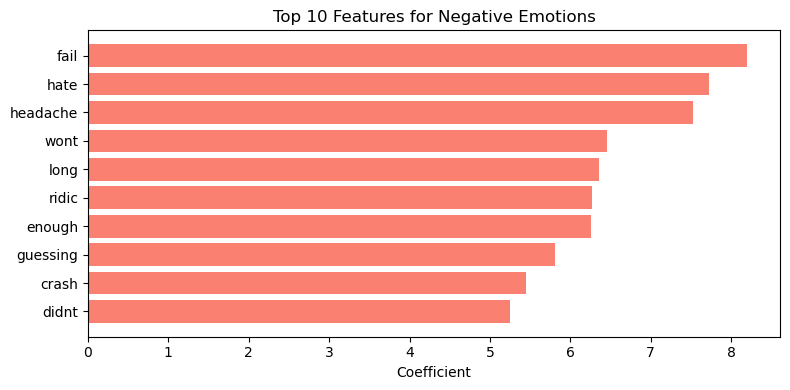

In [65]:
# Find the index of the 'Negative emotion' class
neg_label_idx = np.where(le.inverse_transform(unique_labels) == "Negative emotion")[0][0]

# Get coefficients and top features
neg_coef = coefs[neg_label_idx]
top_idx = np.argsort(neg_coef)[-10:][::-1]
top_words = [tfidf_features[idx] for idx in top_idx]
top_scores = neg_coef[top_idx]

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.barh(top_words[::-1], top_scores[::-1], color='salmon')
plt.xlabel("Coefficient")
plt.title("Top 10 Features for Negative Emotions")
plt.tight_layout()
plt.show()

The visualization above clearly shows what 

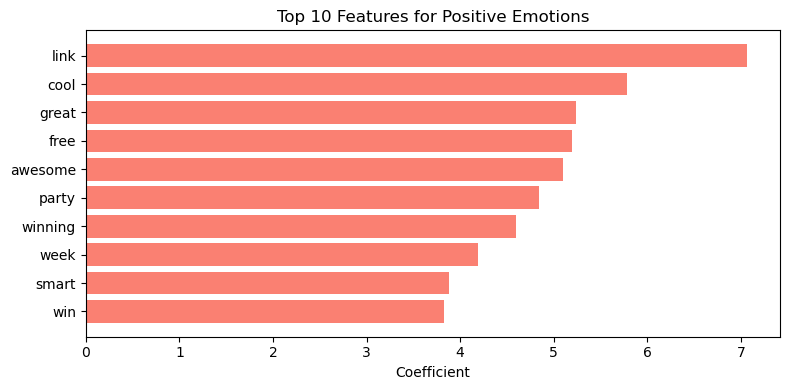

In [66]:
# Find the index of the 'Negative emotion' class
neg_label_idx = np.where(le.inverse_transform(unique_labels) == "Positive emotion")[0][0]

# Get coefficients and top features
neg_coef = coefs[neg_label_idx]
top_idx = np.argsort(neg_coef)[-10:][::-1]
top_words = [tfidf_features[idx] for idx in top_idx]
top_scores = neg_coef[top_idx]

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.barh(top_words[::-1], top_scores[::-1], color='salmon')
plt.xlabel("Coefficient")
plt.title("Top 10 Features for Positive Emotions")
plt.tight_layout()
plt.show()

Interpretation

For Negative Emotion:
The top bars represent words like “fail,” “hate,” “headache.” The longer the bar, the more strongly the model associates that word with negative sentiment. These words are the key “signals” the model uses to classify a tweet as negative.

For Neutral:
The top bars represent words like “link,” “cool,” “great.” They are indicators of neutral content, which often appears in informational or casual tweets.

Key Insights from Visualization

Visual ranking: You can instantly see which words are most predictive of each class.

Class separation: Helps understand how the model distinguishes between negative and neutral tweets.

Model explainability: Shows which words drive predictions, making the model more interpretable to stakeholders.

## 7.0 MULTICLASS MODEL

### 7.1 Pick Best Model and Retrain 
We build and compare multiple models, we then evaluate algorithms such as **Logistic Regression, Random Forest, Gradient Boosting, AdaBoost, and XGBoost**. This helps us benchmark performance and identify the best model for our dataset.

In [67]:
# Add cleaned text column 
df['cleaned_tweet'] = df['tweet_text'].apply(clean_text)


# Features and target for multiclass
X_multi = df['cleaned_tweet']
y_multi = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Encode target labels
le_multi = LabelEncoder()
y_multi_enc = le_multi.fit_transform(y_multi)

# Train-test split (stratified to preserve class balance)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi_enc, test_size=0.2, random_state=42, stratify=y_multi_enc
)
# re-use the previously defined models and evaluation function
# Evaluate models on multiclass data
multi_results = evaluate_models(models, X_train_m, y_train_m)

# Pick the best model based on cross-validation accuracy and retrain it on the full training set
best_model_name = max(multi_results, key=multi_results.get)
print(f"\nBest model: {best_model_name} with accuracy {multi_results[best_model_name]:.4f}") 


Naive Bayes: 0.5124
Logistic Regression: 0.5594
Random Forest: 0.5208
Gradient Boosting: 0.4620
AdaBoost: 0.4545
XGBoost: 0.5132

Best model: Logistic Regression with accuracy 0.5594


### 7.2 Best Multiclas-Model Hyperparameter Tuning (with TF-IDF )

- The model and evaluation function in multiclass gave us Best model: Logistic Regression


In [68]:
multiclass_grid = RandomizedSearchCV(
    ImbPipeline([
        ("tfidf", TfidfVectorizer()),
        ("oversample", RandomOverSampler(random_state=42)),
        ("clf", LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000))
    ]),
    param_distributions=param_dist,
    n_iter=20,   # number of random parameter combinations to try
    cv=3,
    scoring=scoring,
    refit="f1_macro",   # pick the model with best F1 (macro)
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Fit search
multiclass_grid.fit(X_train_m, y_train_m)


# Best model
print("Best Parameters:", multiclass_grid.best_params_)
print("Best CV F1 Score:", multiclass_grid.best_score_)

# Assign tuned pipeline as multi_best_pipeline
multi_best_pipeline_tuned = multiclass_grid.best_estimator_



Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\erastus.kaiba\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best Parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__max_features': 7000, 'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__C': 10.0}
Best CV F1 Score: 0.5562004775219407


### 7.3 multiclass-Model Evaluation and Feature Analysis

Test Accuracy: 0.6795

Classification Report:

                  precision    recall  f1-score   support

Negative emotion       0.42      0.53      0.47       114
         Neutral       0.76      0.73      0.75      1109
Positive emotion       0.59      0.62      0.61       596

        accuracy                           0.68      1819
       macro avg       0.59      0.62      0.61      1819
    weighted avg       0.69      0.68      0.68      1819



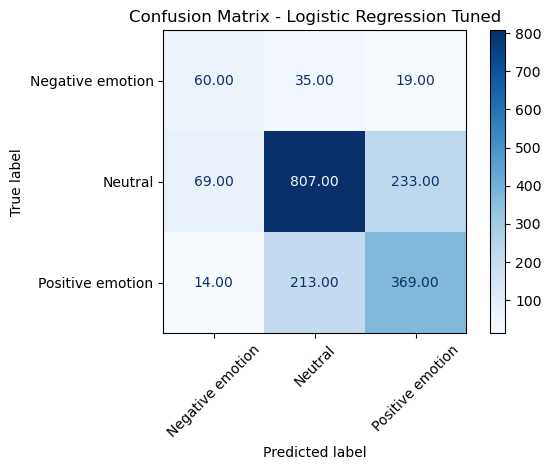

In [69]:
# Predictions
# -----------------------------
y_pred_tuned_m = multi_best_pipeline_tuned.predict(X_test_m)

print(f"Test Accuracy: {accuracy_score(y_test_m, y_pred_tuned_m ):.4f}\n")


print("Classification Report:\n")
print(classification_report(y_test_m, y_pred_tuned_m,target_names=le_multi.classes_))

# -----------------------------
# Confusion matrix
# -----------------------------
cm = confusion_matrix(y_test_m, y_pred_tuned_m)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le_multi.classes_)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Confusion Matrix - Logistic Regression Tuned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
